In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Introduction

This is a project demonstrating various classification techniques on imbalanced dataset, which is quite different from regular classfication problems. The goal is to perform a binary classification of Class0 (Not fraud) and Class1 (fraud). The approach in this notebook will be :

    1. Randomly split the dataset into train and test.
    2. Do basic EDA and feature engineering.
    3. Predict and evaluate with new-featured dataset.
    4. Resample the dataset. 
    5. Predict and evaluate with resampled dataset.
    6. Try other different models.
    7. Compare the difference between the predictions and choose the best model.
    
Some points worth noting are :

    1. The features are mostly PC components(28 out of 30) which we can neither name nor engineer with. 
    2. Since the dataset is highly imbalanced, using accuracy as evaluation metric is not a clever idea, the performance metrics should be Confusion Matrix and PR(precision-recall) curve, or maybe Area under PR curve if a single-number metric is needed.
    3. We should not predict hard labels(0 or 1) at first place but probabilities instead, since the default 0.5 cutoff for labeling might not be suitable for imbalanced dataset.
    4. As a brain refresher, Precision evaluates how many selected items are relevant, while Recall evaluates how many relevant items are selected.

In [26]:
data = pd.read_csv("C:/Users/Jimmy Chen/Desktop/Python code/creditcard.csv")

In [27]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    284315
1       492
Name: Class, dtype: int64

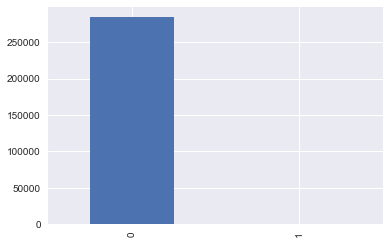

In [28]:
count = pd.value_counts(data['Class'], sort = True).sort_index()
count.plot(kind = 'bar')
count

The two classes are really imbalanced!

## Data Split

We want to split the data randomly into train and test sets, while preserving the ratio of classes in each of them. 

In [29]:
from sklearn.model_selection import train_test_split
y = data['Class']
X = data.drop('Class',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,random_state=5001)
train = pd.concat([X_train, y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)
print("Percentage of fraud transactions in train is: ",round(train.Class.mean(),4))
print("Percentage of fraud transactions in test is: ",round(test.Class.mean(),4))

Percentage of fraud transactions in train is:  0.0017
Percentage of fraud transactions in test is:  0.0017


## EDA and Feature Engeneering

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,199020.0,94804.191780,47458.389948,0.0,54255.0,84619.0,139281.0,172788.0
1,344.0,82116.860465,48120.714881,406.0,41231.5,77010.5,128538.0,170348.0


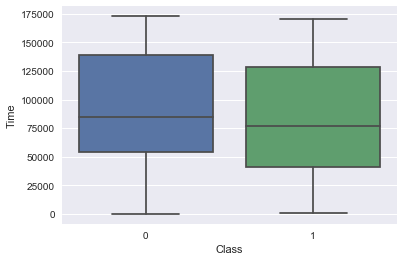

In [30]:
sns.boxplot(x="Class", y="Time",data=train)
train.groupby("Class").Time.describe()

Time itself doesn't seem to determine class well. We will feature a new variable which is the time difference between transaction and the precede transaction. In order to that, we will combine train and test first, do the feature engineering, then split the dataset again. 

In [31]:
data = pd.concat([train,test],axis=0)
#the column names are auto reordered, lets turn it back to what it should be
data = data[list(train.columns.values)]
data.sort_index(inplace=True)
#create the time difference feature
data['Time_Difference'] = data['Time']-data['Time'].shift()
#remove the nan row caused by lag
data.dropna(axis=0,inplace=True)

#split the data set again
y = data['Class']
X = data.drop('Class',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,random_state=8123)
train = pd.concat([X_train, y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)

In [32]:
train.groupby('Class').Time_Difference.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,199020.0,0.605884,1.052679,0.0,0.0,0.0,1.0,32.0
1,344.0,1.066860,1.851217,0.0,0.0,0.0,1.0,16.0


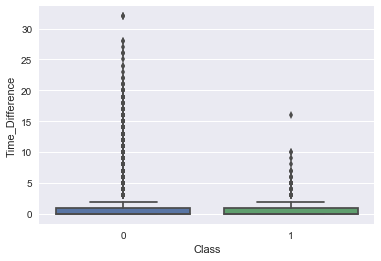

In [33]:
sns.boxplot(x="Class", y="Time_Difference",data=train)

Most of the time difference are similiar, however, some large difference might indicates fraud, as fraud often happens at time that has few transactions. 

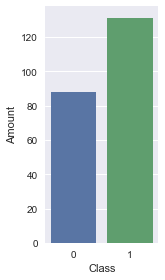

In [34]:
sns.factorplot(x="Class", y="Amount", data=train, kind="bar", ci=None, aspect=.6)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,199020.0,88.264329,248.861164,0.0,5.78,22.000,77.05,19656.53
1,344.0,131.384680,272.563112,0.0,1.00,9.015,111.70,2125.87


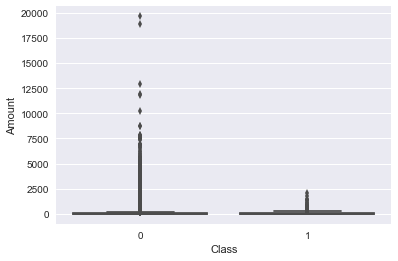

In [35]:
sns.boxplot(x="Class", y="Amount", data=train)
train.groupby('Class').Amount.describe()

Even though average amount of non-fraud is greater than fraud, transaction of large amount however are mostly fraud, which follows our instinct about fraud. We will create a binary factor indicating transaction with large amount, with a threshold of 2000. 

In [36]:
pd.options.mode.chained_assignment = None
def amount_threshold(x):
    if x > 2000: return 1
    else: return 0
    
X_train['Large_Amount'] = X_train['Amount'].apply(amount_threshold)
X_test['Large_Amount'] = X_test['Amount'].apply(amount_threshold)

## Predict and Evaluate - Original set

We will first use logistic regression, with parameter tuned by stratified cross validation, to predict the probability of labels. We use area under Precision-Recall curve, aka average precision score to evaluate the performance. The reason to choose PR AUC over ROC AUC is that PR does not account for true negatives, therefore more suitable for imbalanced classification.

In [37]:
from sklearn.linear_model import LogisticRegressionCV
logCV = LogisticRegressionCV(Cs=[0.01,0.1,1,10,100], scoring='average_precision',verbose=0,
                             max_iter=200,random_state=5001)
logCV.fit(X_train,y_train)
print("The best parameter C is",logCV.C_[0])

The best parameter C is 0.1


We will then use the fitted model to predict our validation (test) set. The output would be a set of probabilities, which we will analyze it with respect to PR-curve.  

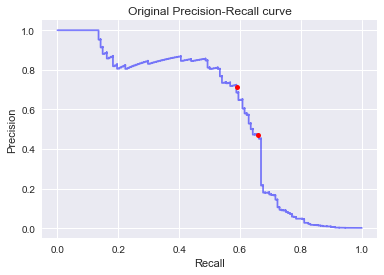

In [38]:
from sklearn.metrics import average_precision_score, precision_recall_curve
pred_prob = logCV.predict_proba(X_test)
y_score = pred_prob[:,1]
average_precision = average_precision_score(y_test, y_score)
original_precision, original_recall, original_thresholds = precision_recall_curve(y_test, y_score)
plt.step(original_recall, original_precision, color='blue', alpha=0.5)
plt.plot([0.59],[0.715],color="red",marker='o', markersize=5)
plt.plot([0.66],[0.47],color="red",marker='o', markersize=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Original Precision-Recall curve')

From the PR curve above, we want to set our threshold to give result like one of the red points indicated, with a nice recall rate while keeping precision rate not too low.

## Data Resampling

It's time to do some resampling to our train set! We will oversample our minority class with SMOTE(Synthetic Minority Over-sampling Technique), which generates new samples similiar but not typically identical of minority classes, since the algorithm takes nearby instances of same class into account. One important thing to mention is that we should NEVER resample our validation test, since it might lead to an over-optimistic performance that is untrustable. 

In [39]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=4001,kind='regular')
X_res, y_res = sm.fit_sample(X_train, y_train)
pd.value_counts(y_res)

1    199020
0    199020
dtype: int64

## Predict and Evaluate - Resampled set

Next we will use logistic regression with the same parameter C=0.1 to test the performance on our same validation(test) set. 

In [40]:
from sklearn.linear_model import LogisticRegression
log_res = LogisticRegression(C=0.1, verbose=0, random_state=5001)
log_res.fit(X_res,y_res)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=5001, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

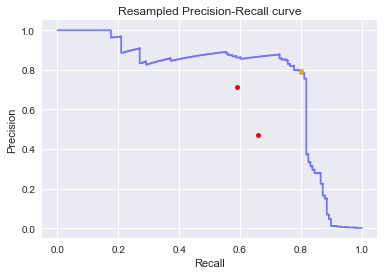

In [41]:
pred_prob = log_res.predict_proba(X_test)
resampled_score = pred_prob[:,1]
average_precision = average_precision_score(y_test, y_score)
resampled_precision, resampled_recall, resampled_thresholds = precision_recall_curve(y_test, resampled_score)
plt.step(resampled_recall, resampled_precision, color='blue', alpha=0.5)
plt.plot([0.59],[0.715],color="red",marker='o', markersize=5)
plt.plot([0.66],[0.47],color="red",marker='o', markersize=5)
plt.plot([0.8],[0.795],color="orange",marker='o', markersize=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Resampled Precision-Recall curve')

Red points are the optimized points from the last model. We can see from the difference that resampling does bring improvement to our model. Next we will approach with different models to see if we can make further improvement. 

## Random Forest - Resampled set

We will now train the well-known random forest algorithm on the resampled train set. Random forest usually have satisfying performance on classification problem, even without complicated model tuning. 

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=4, n_estimators=100, bootstrap=True, random_state=7017)
rf.fit(X_res,y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=7017, verbose=0,
            warm_start=False)

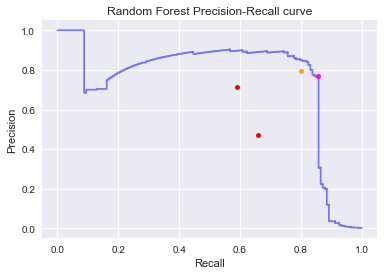

In [43]:
pred_prob = rf.predict_proba(X_test)
rf_score = pred_prob[:,1]
average_precision = average_precision_score(y_test, y_score)
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_test, rf_score)
plt.step(rf_recall, rf_precision, color='blue', alpha=0.5)
plt.plot([0.59],[0.715],color="red",marker='o', markersize=5)
plt.plot([0.66],[0.47],color="red",marker='o', markersize=5)
plt.plot([0.8],[0.795],color="orange",marker='o', markersize=5)
plt.plot([0.855],[0.77],color="magenta",marker='o', markersize=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall curve')

From the comparison of purple and orange point , we can see that while keeping the precision close to the logistic model, we achieved a higher recall rate. 

## Cluster Before Prediction - Original set

We will aproach the problem in a different but intuitive way. The method is called cluster before prediction, with three consecutive steps. First separate the majority class into clusters, say 20 clusters. Then we will combine each segment with all minority samples to train 20 models. Finally, we predict the test set with these models, averaging all of them to get a final prediction. We will train random forest classifiers since it generates better result comparing to logistic regression.

In [44]:
from sklearn.cluster import KMeans
X_train_minority, X_train_majority = X_train[y_train==1], X_train[y_train==0]
kmeans = KMeans(n_clusters=20, random_state=5001).fit(X_train_majority)

kmeans.labels

In [45]:
prediction = [0]*len(X_test)
for i in range(0,20):
        majority_segment = X_train_majority[kmeans.labels_==i]
        X_train_segment = pd.concat([majority_segment,X_train_minority])
        y_train_segment = [0]*len(majority_segment)+[1]*len(X_train_minority)
        rf = RandomForestClassifier(max_depth=4, n_estimators=100, bootstrap=True,random_state=7001)
        rf.fit(X_train_segment,y_train_segment)
        pred_prob = rf.predict_proba(X_test)
        prediction = np.add(prediction, pred_prob[:,1])
prediction = prediction/20            

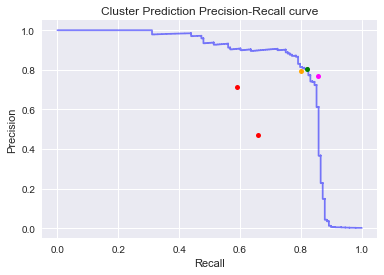

In [46]:
y_score = prediction
average_precision = average_precision_score(y_test, y_score)
cls_precision, cls_recall, cls_thresholds = precision_recall_curve(y_test, y_score)
plt.step(cls_recall, cls_precision, color='blue', alpha=0.5)
plt.plot([0.59],[0.715],color="red",marker='o', markersize=5)
plt.plot([0.66],[0.47],color="red",marker='o', markersize=5)
plt.plot([0.8],[0.795],color="orange",marker='o', markersize=5)
plt.plot([0.855],[0.77],color="magenta",marker='o', markersize=5)
plt.plot([0.82],[0.805],color="green",marker='o', markersize=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Cluster Prediction Precision-Recall curve')

The result of optimised point is a little worse than modeling of resampled train set. However, the left part of the graph indicates big improvement on keeping high precision rate when recall rate is about 0.2 - 0.4. Another thing to mention is that even though we segmented the data into 20 clusters, the data in each cluster is still imbalanced. Therefore, this method might be a good choice for problems that are not extremely imbalanced like this one. 

## Overall Comparison 

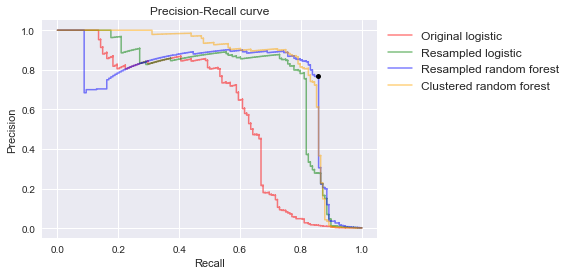

In [47]:
plt.step(original_recall, original_precision, color='red', alpha=0.5,linewidth=1.5,label='Original logistic')
plt.step(resampled_recall, resampled_precision, color='green', alpha=0.5,linewidth=1.5,label='Resampled logistic')
plt.step(rf_recall, rf_precision, color='blue', alpha=0.5,linewidth=1.5,label='Resampled random forest')
plt.step(cls_recall, cls_precision, color='orange', alpha=0.5,linewidth=1.5,label='Clustered random forest')
plt.plot([0.855],[0.77],color="black",marker='o', markersize=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')

plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize = 'large')

Since we concern mostly about achieving high recall rate as well as keeping a good precision rate, the blue line, resampled random forest, seems to be the model of best performance. With our model chosen, we will now find the threshold for the black point which indicates the precision and recall we want. 

In [48]:
error = []
for recall, precision in zip(rf_recall, rf_precision):
    err = (recall-0.855)**2 + (precision-0.77)**2
    error.append(err)
error = np.asarray(error)
min_index = np.where(error==min(error))
opt_threshold = rf_thresholds[min_index]

## Confusion Matrix

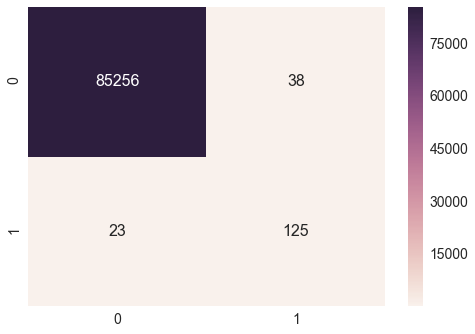

In [69]:
from sklearn.metrics import confusion_matrix
y_pred = [1 if x > opt_threshold else 0 for x in rf_score]
conf = confusion_matrix(y_test,y_pred)
conf = pd.DataFrame(conf, range(2),range(2))
sns.heatmap(conf, annot=True, fmt='g', annot_kws={"size": 16})

## Conclusion

For this project we investigated whether resampling technique can bring improvement to model of imbalanced classification. From what I see, I believe that the answer is yes, however there are something I would like to mention additional to the analyis. 
    
    1. Tuning parameters of resampled model with cross validation can possibly improve our model, however, we should not do cv after oversampling or else the oversampled validation slice of each fold won't be a good estimate of test set. The proper steps to do cv for each fold is to first select a validation set and leave it unchanged, oversample the remain data, and finally test the trained model on unchanged validation set. 
    2. There are other oversample techniques such as ROSE that we didn't try but can possibly improve our model. Undersampling techniques might be a suitable choice too. 